<a href="https://colab.research.google.com/github/Pavithra777/EVA-8-Phase-1/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from google.colab import files
src = list(files.upload().values())[0]
open('/content/model.py','wb').write(src)
from model import Net

Saving model.py to model (1).py


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.RandomRotation((-6.0, 6.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
wrong_img = {"GN":[],"LN":[],"BN":[]}
pred_label = {"GN":[],"LN":[],"BN":[]}
target_label = {"GN":[],"LN":[],"BN":[]}
train_losses_dict = {"GN":[],"LN":[],"BN":[]}
test_losses_dict = {"GN":[],"LN":[],"BN":[]}
train_acc_dict = {"GN":[],"LN":[],"BN":[]}
test_acc_dict = {"GN":[],"LN":[],"BN":[]}
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Net(normalization_type="GN").to(device)
summary(model, input_size=(1, 28, 28))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
         GroupNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 24, 22, 22]           3,456
              ReLU-8           [-1, 24, 22, 22]               0
         GroupNorm-9           [-1, 24, 22, 22]              48
        MaxPool2d-10           [-1, 24, 11, 11]               0
           Conv2d-11            [-1, 8, 11, 11]             192
             ReLU-12            [-1, 8, 11, 11]               0
    

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch,normalization_type,loss_l1 =False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if(loss_l1):
      l1=0
      lamba_l1 = 1e-5
      for p in model.parameters():
        l1=l1+p.abs().sum()
      loss = loss+lamba_l1*l1
    train_losses_dict[normalization_type].append(loss.data.cpu().numpy().item())
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    if pred.eq(target.view_as(pred))[0]==False and len(wrong_img[normalization_type])<10:
      wrong_img[normalization_type].append(data.cpu().numpy()[0][0])
      target_label[normalization_type].append(target.cpu().numpy()[0])
      pred_label[normalization_type].append(pred.cpu().numpy()[0][0])


    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_dict[normalization_type].append(100*correct/processed)
    

def test(model, device, test_loader,normalization_type):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_dict[normalization_type].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_dict[normalization_type].append(100. * correct / len(test_loader.dataset))
    

In [ ]:
from torch.optim.lr_scheduler import StepLR
def train_and_test(normalization,l1_loss):
  model =  Net(normalization).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
  EPOCHS = 20
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch,normalization,l1_loss)
      test(model, device, test_loader,normalization)


# Network with Group Normalization

In [ ]:

from torch.optim.lr_scheduler import StepLR
normalization = "GN"
train_and_test(normalization,False)

EPOCH: 0


Loss=0.18286724388599396 Batch_id=468 Accuracy=88.04: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]



Test set: Average loss: 0.0893, Accuracy: 9779/10000 (97.79%)

EPOCH: 1


Loss=0.0738384947180748 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:21<00:00, 21.64it/s]



Test set: Average loss: 0.0633, Accuracy: 9829/10000 (98.29%)

EPOCH: 2


Loss=0.05749960243701935 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:18<00:00, 25.90it/s]



Test set: Average loss: 0.0583, Accuracy: 9825/10000 (98.25%)

EPOCH: 3


Loss=0.04338245466351509 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]



Test set: Average loss: 0.0433, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.06119994819164276 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]



Test set: Average loss: 0.0400, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.09226112812757492 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]



Test set: Average loss: 0.0339, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.02153342217206955 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]



Test set: Average loss: 0.0393, Accuracy: 9872/10000 (98.72%)

EPOCH: 7


Loss=0.03382260724902153 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]



Test set: Average loss: 0.0343, Accuracy: 9890/10000 (98.90%)

EPOCH: 8


Loss=0.008033006452023983 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 26.98it/s]



Test set: Average loss: 0.0323, Accuracy: 9895/10000 (98.95%)

EPOCH: 9


Loss=0.08664456754922867 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0314, Accuracy: 9904/10000 (99.04%)

EPOCH: 10


Loss=0.026902765035629272 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.44it/s]



Test set: Average loss: 0.0315, Accuracy: 9907/10000 (99.07%)

EPOCH: 11


Loss=0.0747927874326706 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]



Test set: Average loss: 0.0307, Accuracy: 9912/10000 (99.12%)

EPOCH: 12


Loss=0.06710044294595718 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]



Test set: Average loss: 0.0296, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.007825908251106739 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]



Test set: Average loss: 0.0300, Accuracy: 9907/10000 (99.07%)

EPOCH: 14


Loss=0.13915932178497314 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]



Test set: Average loss: 0.0284, Accuracy: 9905/10000 (99.05%)

EPOCH: 15


Loss=0.012773965485394001 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]



Test set: Average loss: 0.0297, Accuracy: 9906/10000 (99.06%)

EPOCH: 16


Loss=0.05082428827881813 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 27.08it/s]



Test set: Average loss: 0.0278, Accuracy: 9913/10000 (99.13%)

EPOCH: 17


Loss=0.006530763581395149 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0321, Accuracy: 9906/10000 (99.06%)

EPOCH: 18


Loss=0.016638217493891716 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s]



Test set: Average loss: 0.0260, Accuracy: 9912/10000 (99.12%)

EPOCH: 19


Loss=0.004023162182420492 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:17<00:00, 27.49it/s]



Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)



# Network with Layer Normalization


In [ ]:

from torch.optim.lr_scheduler import StepLR
normalization = "LN"
train_and_test(normalization,False)


EPOCH: 0


Loss=0.0968773141503334 Batch_id=468 Accuracy=88.17: 100%|██████████| 469/469 [00:19<00:00, 23.52it/s]



Test set: Average loss: 0.0994, Accuracy: 9746/10000 (97.46%)

EPOCH: 1


Loss=0.03250936418771744 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s]



Test set: Average loss: 0.0654, Accuracy: 9818/10000 (98.18%)

EPOCH: 2


Loss=0.03565976396203041 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]



Test set: Average loss: 0.0491, Accuracy: 9862/10000 (98.62%)

EPOCH: 3


Loss=0.04799222946166992 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s]



Test set: Average loss: 0.0464, Accuracy: 9851/10000 (98.51%)

EPOCH: 4


Loss=0.01091375295072794 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:18<00:00, 25.95it/s]



Test set: Average loss: 0.0414, Accuracy: 9880/10000 (98.80%)

EPOCH: 5


Loss=0.045286450535058975 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 26.98it/s]



Test set: Average loss: 0.0390, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.040048498660326004 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:18<00:00, 26.05it/s]



Test set: Average loss: 0.0363, Accuracy: 9889/10000 (98.89%)

EPOCH: 7


Loss=0.03261462226510048 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]



Test set: Average loss: 0.0333, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.06047208234667778 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0354, Accuracy: 9899/10000 (98.99%)

EPOCH: 9


Loss=0.038140177726745605 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.0296, Accuracy: 9906/10000 (99.06%)

EPOCH: 10


Loss=0.08833268284797668 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]



Test set: Average loss: 0.0331, Accuracy: 9905/10000 (99.05%)

EPOCH: 11


Loss=0.0514226071536541 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 25.37it/s]



Test set: Average loss: 0.0278, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.014612112194299698 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]



Test set: Average loss: 0.0280, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.017337311059236526 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]



Test set: Average loss: 0.0288, Accuracy: 9910/10000 (99.10%)

EPOCH: 14


Loss=0.005628690123558044 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]



Test set: Average loss: 0.0301, Accuracy: 9903/10000 (99.03%)

EPOCH: 15


Loss=0.04126029089093208 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.36it/s]



Test set: Average loss: 0.0277, Accuracy: 9919/10000 (99.19%)

EPOCH: 16


Loss=0.050802458077669144 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 26.29it/s]



Test set: Average loss: 0.0293, Accuracy: 9905/10000 (99.05%)

EPOCH: 17


Loss=0.03033371828496456 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.99it/s]



Test set: Average loss: 0.0325, Accuracy: 9894/10000 (98.94%)

EPOCH: 18


Loss=0.009939010255038738 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:18<00:00, 25.45it/s]



Test set: Average loss: 0.0277, Accuracy: 9910/10000 (99.10%)

EPOCH: 19


Loss=0.016579503193497658 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:17<00:00, 26.79it/s]



Test set: Average loss: 0.0278, Accuracy: 9905/10000 (99.05%)



# Network with L1 + BN



In [ ]:
from torch.optim.lr_scheduler import StepLR
normalization = "BN"
train_and_test(normalization,True)

EPOCH: 0


Loss=0.10717283189296722 Batch_id=468 Accuracy=87.49: 100%|██████████| 469/469 [00:18<00:00, 25.29it/s]



Test set: Average loss: 0.0965, Accuracy: 9769/10000 (97.69%)

EPOCH: 1


Loss=0.07972970604896545 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]



Test set: Average loss: 0.0553, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.06360599398612976 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]



Test set: Average loss: 0.0512, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.05127619579434395 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]



Test set: Average loss: 0.0438, Accuracy: 9871/10000 (98.71%)

EPOCH: 4


Loss=0.1167607307434082 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:18<00:00, 25.95it/s]



Test set: Average loss: 0.0344, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


Loss=0.01691218838095665 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s]



Test set: Average loss: 0.0347, Accuracy: 9889/10000 (98.89%)

EPOCH: 6


Loss=0.021436313167214394 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0342, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.034507907927036285 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]



Test set: Average loss: 0.0312, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.029812773689627647 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]



Test set: Average loss: 0.0293, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.011741148307919502 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]



Test set: Average loss: 0.0307, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss=0.02793729305267334 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 26.05it/s]



Test set: Average loss: 0.0332, Accuracy: 9898/10000 (98.98%)

EPOCH: 11


Loss=0.04909191280603409 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:17<00:00, 26.11it/s]



Test set: Average loss: 0.0338, Accuracy: 9896/10000 (98.96%)

EPOCH: 12


Loss=0.014209624379873276 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:19<00:00, 24.43it/s]



Test set: Average loss: 0.0305, Accuracy: 9907/10000 (99.07%)

EPOCH: 13


Loss=0.021528927609324455 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]



Test set: Average loss: 0.0286, Accuracy: 9913/10000 (99.13%)

EPOCH: 14


Loss=0.05560774356126785 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]



Test set: Average loss: 0.0266, Accuracy: 9915/10000 (99.15%)

EPOCH: 15


Loss=0.04314453527331352 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 26.13it/s]



Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)

EPOCH: 16


Loss=0.019565552473068237 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]



Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)

EPOCH: 17


Loss=0.05521264299750328 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]



Test set: Average loss: 0.0263, Accuracy: 9913/10000 (99.13%)

EPOCH: 18


Loss=0.01775834523141384 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s]



Test set: Average loss: 0.0277, Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.0348467156291008 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:17<00:00, 26.09it/s]



Test set: Average loss: 0.0296, Accuracy: 9903/10000 (99.03%)



In [ ]:
len(wrong_img['BN'])

10

GN
LN
BN


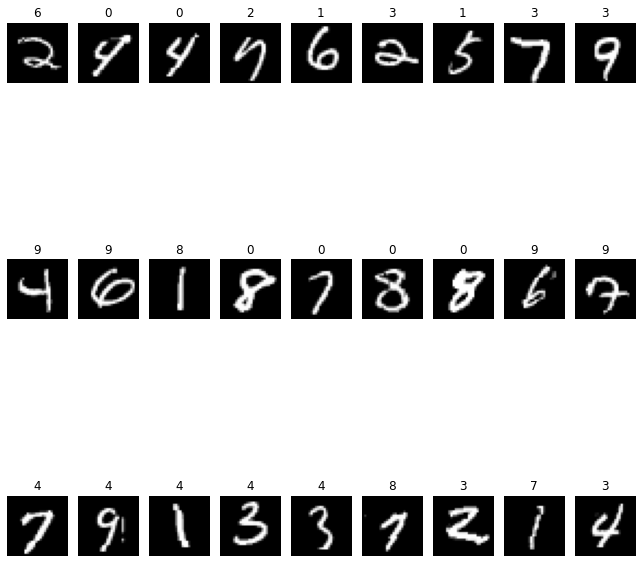

In [ ]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 10))
cols, rows = 10, 3
row_num =0

for normalization in wrong_img:
  print(normalization)
  for i in range(0, cols-1):
      img =wrong_img[normalization][i]
      label =  pred_label[normalization][i]
      figure.add_subplot(rows, cols, (row_num*cols)+ i+1)
      plt.title(label)
      plt.axis("off")
      plt.imshow(img, cmap="gray")
  row_num+=1
figure.tight_layout()
plt.show()

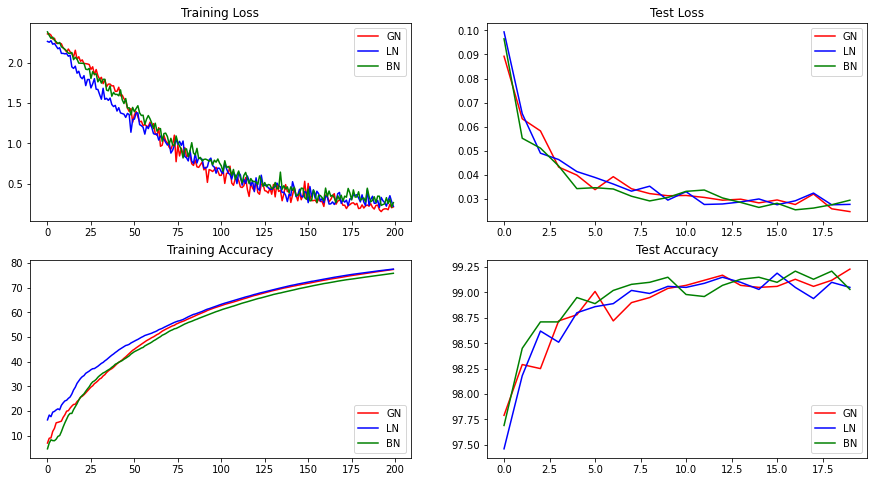

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,8))
axs[0, 0].plot(train_losses_dict['GN'][:200],color='r', label='GN')
axs[0, 0].plot(train_losses_dict['LN'][:200],color='b', label='LN')
axs[0, 0].plot(train_losses_dict['BN'][:200],color='g', label='BN')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_dict['GN'][:200],color='r', label='GN')
axs[1, 0].plot(train_acc_dict['LN'][:200],color='b', label='LN')
axs[1, 0].plot(train_acc_dict['BN'][:200],color='g', label='BN')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_dict['GN'],color='r', label='GN')
axs[0, 1].plot(test_losses_dict['LN'],color='b', label='LN')
axs[0, 1].plot(test_losses_dict['BN'],color='g', label='BN')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_dict['GN'],color='r', label='GN')
axs[1, 1].plot(test_acc_dict['LN'],color='b', label='LN')
axs[1, 1].plot(test_acc_dict['BN'],color='g', label='BN')
axs[1, 1].set_title("Test Accuracy")
leg = axs[0, 0].legend(loc='upper right')
leg = axs[0, 1].legend(loc='upper right')
leg = axs[1, 0].legend(loc='lower right')
leg = axs[1, 1].legend(loc='lower right')